# Explore 2016 Regular Season NFL Plays

## Questions to explore:
1. How many total cleaned, usable plays exist in this selection of data?
2. Do all teams have the same number of usable plays?
3. What's the overal count distribution of the six play types?
    - Pass vs Rush for each of three directions: Left, Middle, vs Right
4. What trends occur across sequences of plays?
5. How do game situations affect these trends?
    - down & distance, quarter
6. How do the distributions of potentially important features vary across play types and teams?

Preprocessed in the notebook titled 'plays_wrangle.'  
Raw data from [nfldb](https://github.com/BurntSushi/nfldb)

In [1]:
import re, math
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import nfldb
import sys
import matplotlib as mpl
import seaborn as sns
from __future__ import division
#import psycopg2 as pg
# configure matplotlib plots
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = [12, 9]#[10, 7.5]
mpl.rcParams['figure.dpi'] = 90
mpl.rcParams['savefig.dpi'] = 100
# configure seaborn plots
sns.set(style="whitegrid", color_codes=True)

yrType = '2016 Regular Season'

In [2]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(174, 199, 232), (31, 119, 180), (255, 127, 14), (152, 223, 138),
             (255, 187, 120), (255, 152, 150), (44, 160, 44), (214, 39, 40),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

In [2]:
# functions
def icol(df, cols):
    return [i for i, dfCol in enumerate(df.columns) for col in cols if dfCol==col]

def appStrs(cols, string):
    return [c + string for c in cols]

In [3]:
# load proccessed data
plays = pd.read_csv('data/2016_reg_plays_gd.csv')

In [4]:
# play lables
playType = ['pass', 'rush']
playDir = ['left', 'up the middle', 'right']
playCols = [t + '_' + d[-6:] for t in playType for d in playDir]
# Feature column names: primarily cum sum stats columns - initially
col2cum = [c for c in plays.columns for x in ['first', 'third', 'fourth', 'penalty', 'offense', 'passing', 'receiving', 'rushing'] if c.startswith(x) and not c.endswith('downs') and not c.endswith('_sh1') and not c.endswith('cum_dr') and not c.endswith('cum_gm')]
gcumCols = appStrs(col2cum, '_cum_gm')
dcumCols = appStrs(col2cum, '_cum_dr')
cumCols = gcumCols + dcumCols
prevPlay = appStrs(col2cum, '_sh1')
plays.pos_team = plays.pos_team.astype('category')
plays['pos_team_code'] = plays.pos_team.cat.codes
adfeat = ['quarter_code', 'qtr_timef', 'pos_team_code', 'down', 'yards_to_go', 'score_diff']
features = cumCols + prevPlay + adfeat
### - INCORPORATE THESE INTO plays_setup in future feature engineering
# DRIVE cumulative stats: fill NaN in columns with 0
plays[dcumCols] = plays[dcumCols].fillna(0)
# GAME cumulative stats: fill NaN in columns with forward fill
plays[gcumCols] = plays.groupby(['gsis_id', 'pos_team'])[gcumCols].fillna(method='ffill')
# GAME: cumulative stats: fill first play of game with 0
plays[gcumCols] = plays[gcumCols].fillna(0)
# Noncumulative, shifted stats: fill first play of game with 0
plays[prevPlay] = plays[prevPlay].fillna(0)
###
plays.play = plays.play.astype('category')
plays['play_code'] = plays.play.cat.codes

In [7]:
plays = plays.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1)
plays.head()

gsis_id pos_team  drive_id  \
0  2016090800      CAR         2   
1  2016090800      CAR         2   
2  2016090800      CAR         2   
3  2016090800      CAR         2   
4  2016090800      CAR         2   

                                         description  down  \
0  (11:37) J.Stewart up the middle to CAR 35 for ...   1.0   
1  (11:01) (Shotgun) J.Stewart left end to CAR 46...   2.0   
2  (10:21) (Shotgun) M.Tolbert right guard to CAR...   1.0   
3  (9:39) (Shotgun) C.Newton pass incomplete shor...   2.0   
4  (9:35) (Shotgun) C.Newton pass deep middle to ...   3.0   

                                               drive  first_down  \
0  [Touchdown   ] CAR from OWN 29 to OPP 14 (last...           0   
1  [Touchdown   ] CAR from OWN 29 to OPP 14 (last...           1   
2  [Touchdown   ] CAR from OWN 29 to OPP 14 (last...           0   
3  [Touchdown   ] CAR from OWN 29 to OPP 14 (last...           0   
4  [Touchdown   ] CAR from OWN 29 to OPP 14 (last...           1   

   fourth_down_att  fourth_down_conv  fourth_down_failed    ...     \
0                0                 0                   0    ...      
1                0                 0                   0    ...      
2                0                 0                   0    ...      
3                0                 0                   0    ...      
4                0                 0                   0    ...      

   third_down_failed_cum_gm  penalty_yards_cum_gm  quarter  qtr_time  \
0                       0.0                   0.0       Q1     11:37   
1                       0.0                   0.0       Q1     11:01   
2                       0.0                   0.0       Q1     10:21   
3                       0.0                   0.0       Q1     09:39   
4                       0.0                   0.0       Q1     09:35   

   quarter_code  qtr_min   qtr_sec  qtr_timef  pos_team_code play_code  
0             1     11.0  0.616667  11.616667              4         4  
1             1     11.0  0.016667  11.016667              4         3  
2             1     10.0  0.350000  10.350000              4         5  
3             1      9.0  0.650000   9.650000              4         1  
4             1      9.0  0.583333   9.583333              4         1  

[5 rows x 236 columns]

In [9]:
print('\n{0} plays - Total count of usuable plays in 2016 Regular Season, with current selection setup\n'.format(plays.shape[0]))
print('\n{0} plays - Estimated total number of usuable plays in nfldb, with current selection setup\n'.format(plays.shape[0]*10))


31769 plays - Total count of usuable plays in 2016 Regular Season, with current selection setup


317690 plays - Estimated total number of usuable plays in nfldb, with current selection setup



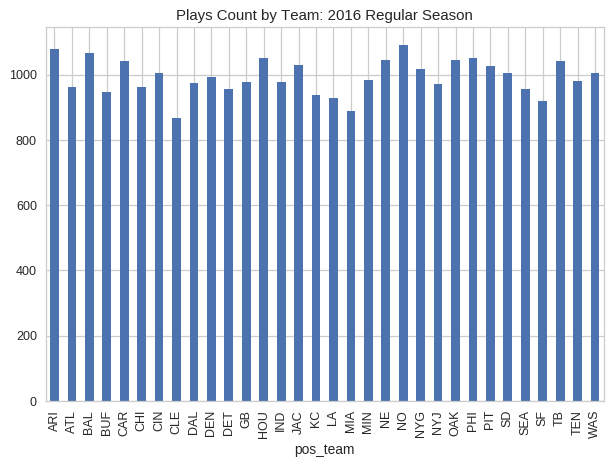

In [10]:
plays.groupby('pos_team').play.size().plot.bar(title='Plays Count by Team: {0}'.format(yrType))

Play counts across teams are rougly similar across teams within ~200.

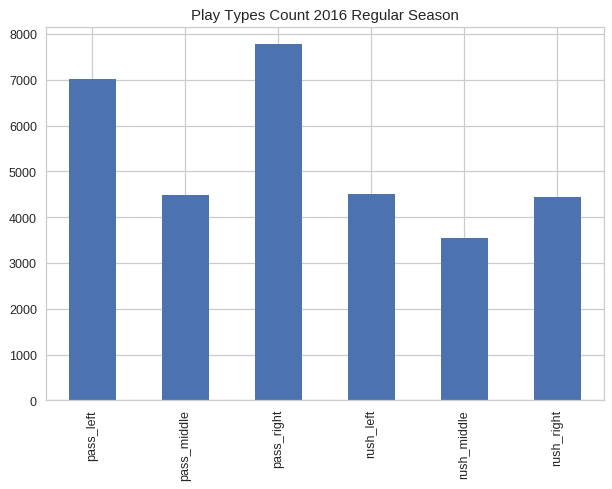

In [12]:
plays.play.value_counts().sort_index().plot.bar(title='Play Types Count {0}'.format(yrType))

As expected with the proliferation of passing in todays NFL, there are more passing than rushing plays. For pass plays the direction of the plays skew right, perhaps due to the greater number of right-handed quarterbacks in the NFL. Pass and rush Plays exhibit the same pattern, with fewer plays directed over the middle of the field. Most importantly, the class inbalances are taken into account in machine learning implementations on these data.

### I ran a quick Random Forest on the data, using 10-fold Cross Validation, to obtain some initial rank of feature importances. 

### load random forest feature importances

In [5]:
# load random forest feature importances
f1 = np.load('data/feature_imp_rf10.npz')
f2 = np.load('data/acc_rf10.npz')
importances = f1['importances']
idx = f1['idx']
stds = f1['stds']
predictions = f2['predictions']
accuracies = f2['accuracies']

In [6]:
# get top 88 features (higher ranked from Random Forest algorithm)
ix = np.argmax(idx[0]==113)
idx[0][ix]
features = np.array(features)
impf = features[idx[0][:ix]]
impf = np.hstack((impf, ['gsis_id', 'pos_team', 'drive_id', 'play'], playCols))

In [7]:
# plays df with "more important" features (higher ranked from RF algorithm)
pfi = plays[impf]
del plays

teams = pfi['pos_team'].unique().sort_values()

In [9]:
impf#[:6]

array(['qtr_timef', 'pos_team_code', 'rushing_yds_cum_gm',
       'offense_yds_cum_gm', 'passing_incmp_air_yds_cum_gm',
       'penalty_yards_cum_gm', 'passing_cmp_air_yds_cum_gm',
       'receiving_yac_yds_cum_gm', 'score_diff', 'passing_yds_cum_gm',
       'receiving_yds_cum_gm', 'rushing_att_cum_gm', 'yards_to_go',
       'receiving_tar_cum_gm', 'passing_att_cum_gm', 'offense_yds_cum_dr',
       'passing_incmp_cum_gm', 'penalty_yds_cum_gm', 'first_down_cum_gm',
       'rushing_yds_cum_dr', 'offense_yds_sh1', 'receiving_rec_cum_gm',
       'passing_cmp_cum_gm', 'third_down_att_cum_gm',
       'penalty_yards_cum_dr', 'passing_first_down_cum_gm',
       'rushing_first_down_cum_gm', 'passing_cmp_air_yds_cum_dr',
       'third_down_failed_cum_gm', 'penalty_yards_sh1',
       'receiving_yac_yds_cum_dr', 'passing_yds_cum_dr',
       'receiving_yds_cum_dr', 'third_down_conv_cum_gm', 'down',
       'penalty_cum_gm', 'rushing_yds_sh1', 'rushing_att_cum_dr',
       'passing_incmp_air_yds_cum_d

# Plot cumulative Game stats

SUMS within play types for each team


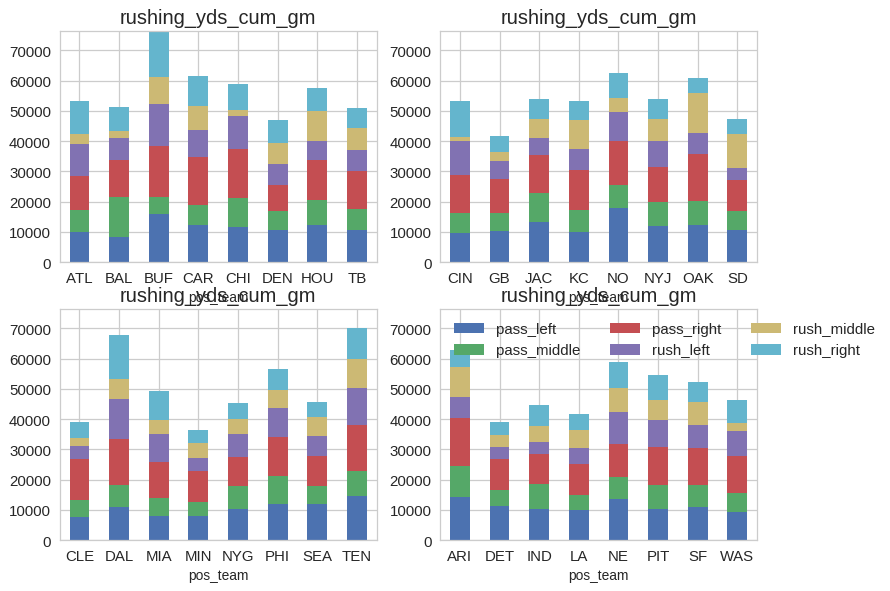

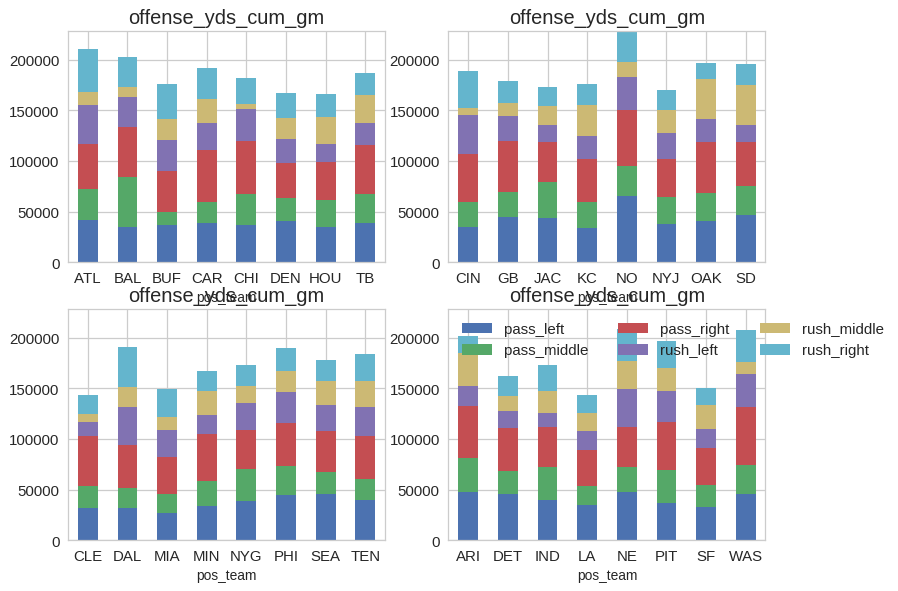

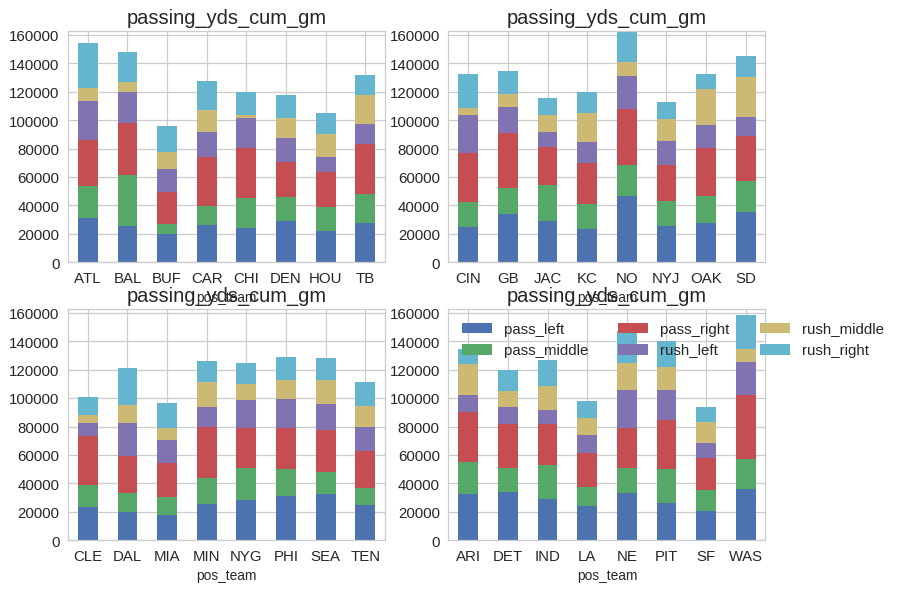

In [22]:
# Plot Game cumulative stats
toPlot = ['offense_yds_cum_gm', 
          'rushing_yds_cum_gm',
          'passing_yds_cum_gm'
          'passing_first_down_cm_gm',
          'rushing_first_down_cum_gm',]
cum_gm = [f for f in impf if f in toPlot]
print('SUMS within play types for each team')
for f in cum_gm:
    #f = 'rushing_yds_cum_gm'
    # configure max ylim across teams
    ymax = pfi.groupby(['pos_team', 'play'])[f].sum().unstack().sum(1).max()
    # round ylim up: to nearest 10000
    #m + (250 - m) % 250
    ymax = math.ceil(ymax / 10) * 10.0
    fig = plt.figure()
    #fig, axes = plt.subplots(2, 2)
    mpl.rcParams['font.size'] = 24
    axshow = False, False, False, True
    for i in range(0, len(teams), 8):
        j = i//8+1
        team8 = (pfi['pos_team']==teams[i]) | (pfi['pos_team']==teams[i+1]) | (pfi['pos_team']==teams[i+2]) | (pfi['pos_team']==teams[i+3]) | (pfi['pos_team']==teams[i+4]) | (pfi['pos_team']==teams[i+5]) | (pfi['pos_team']==teams[i+6]) | (pfi['pos_team']==teams[i+7])
        d = pfi[team8]
        ax = fig.add_subplot(2, 2, j)
        d.groupby(['pos_team', 'play'])[f].sum().unstack().plot.bar(ax=ax, ylim=(0, ymax), stacked=True, figsize=[10, 7.5], fontsize=12, rot=0, legend=axshow[j-1])
        ax.set_title(f, fontsize=16)
        if j == 4:
            ax.legend(loc=2, ncol=3, fontsize=12)


### General patterns in above plots
* pass yards outweigh rush yards, consistently across teams
* cummulative rush and pass yards across the game vary widely across teams

## Plot PREVIOUS PLAY stats

MEANS within play types for each team


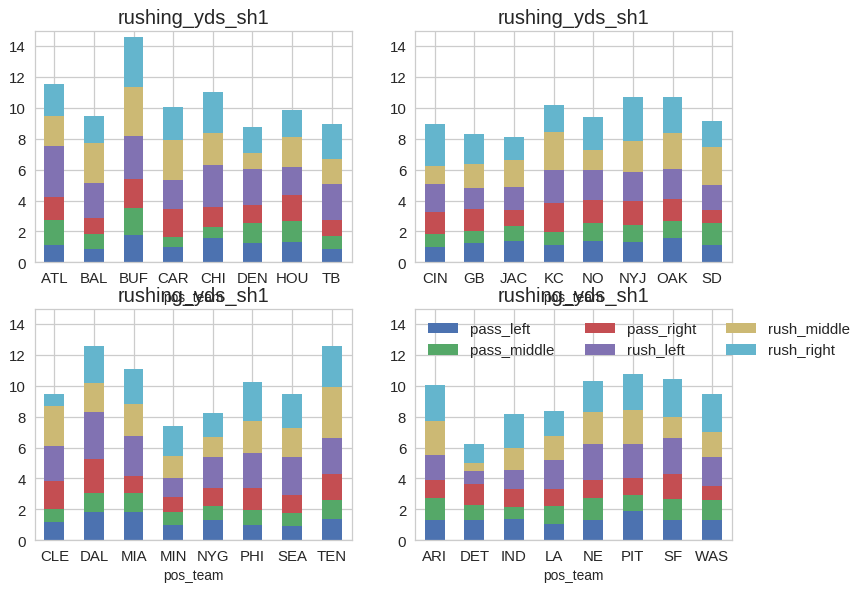

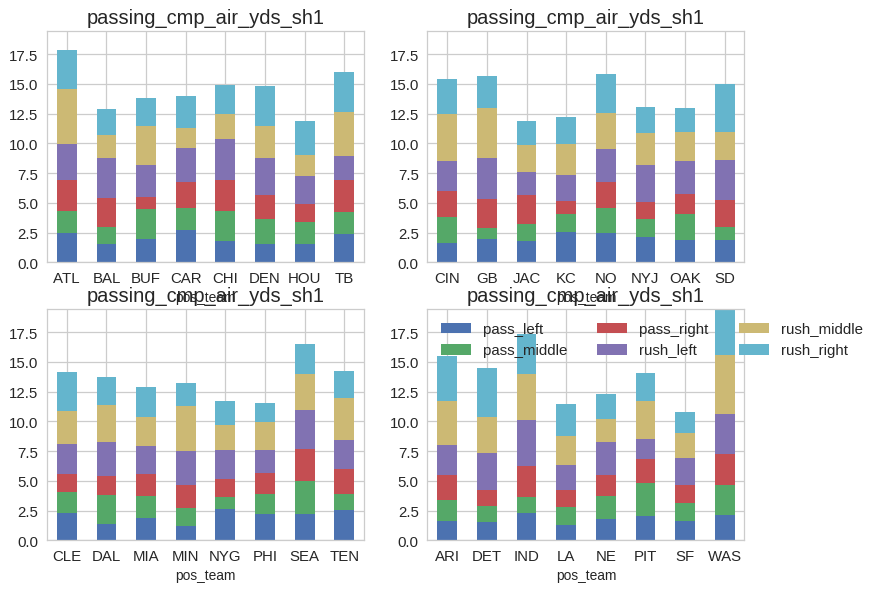

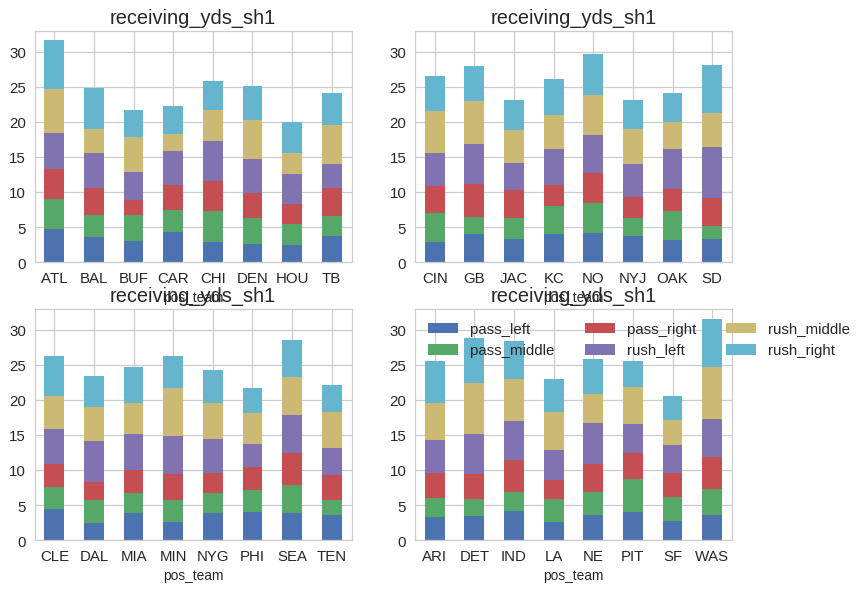

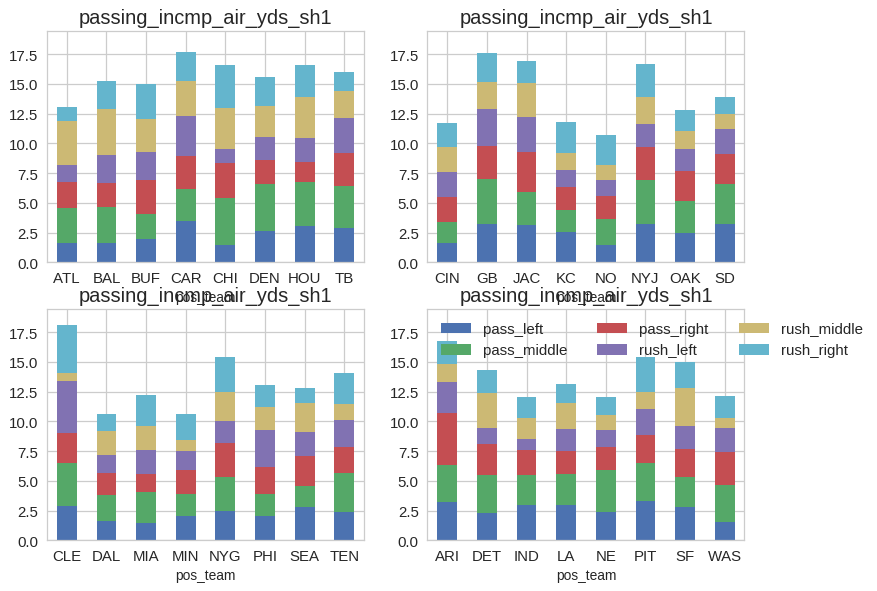

In [9]:
# Plot Prev Play stats
toPlot = ['rushing_yds_sh1',
          'passing_incmp_air_yds_sh1',
          'passing_cmp_air_yds_sh1', 
          'receiving_yds_sh1']
play_sh1 = [f for f in impf if f in toPlot]
print('MEANS within play types for each team')
for f in play_sh1:
    #f = 'rushing_yds_cum_gm'
    # configure max ylim across teams
    ymax = pfi.groupby(['pos_team', 'play'])[f].mean().unstack().sum(1).max()
    # round ylim up: to nearest 10000
    #m + (250 - m) % 250
    ymax = math.ceil(ymax / 1.5) * 1.5
    fig = plt.figure()
    #fig, axes = plt.subplots(2, 2)
    mpl.rcParams['font.size'] = 24
    axshow = False, False, False, True
    for i in range(0, len(teams), 8):
        j = i//8+1
        team8 = (pfi['pos_team']==teams[i]) | (pfi['pos_team']==teams[i+1]) | (pfi['pos_team']==teams[i+2]) | (pfi['pos_team']==teams[i+3]) | (pfi['pos_team']==teams[i+4]) | (pfi['pos_team']==teams[i+5]) | (pfi['pos_team']==teams[i+6]) | (pfi['pos_team']==teams[i+7])
        d = pfi[team8]
        ax = fig.add_subplot(2, 2, j)
        d.groupby(['pos_team', 'play'])[f].mean().unstack().plot.bar(ax=ax, ylim=(0, ymax), stacked=True, figsize=[10, 7.5], fontsize=12, rot=0, legend=axshow[j-1])
        ax.set_title(f, fontsize=16)
        if j == 4:
            ax.legend(loc=2, ncol=3, fontsize=12)
#plt.close('all')

### General patterns in above plots
* if previous play has more rush yards, next play more likely to be a rush
* if previous play has an incomplete pass with more yards in air, next play more likely to be pass
* if previous play has more pass yards in the air, next play more likely to be run
* if previous play has higher receiving yards, next play more likely to be a run
    - fairly consistent across teams


In [35]:
plt.close('all')

## Distribution of cumulative rushing yards within each drive by play type and down for each team

* passes are more likely to occur on 3rd down regardless of how many rush yards a team has accrued on the drive
* teams vary substantially in the total rush yards gained on drives

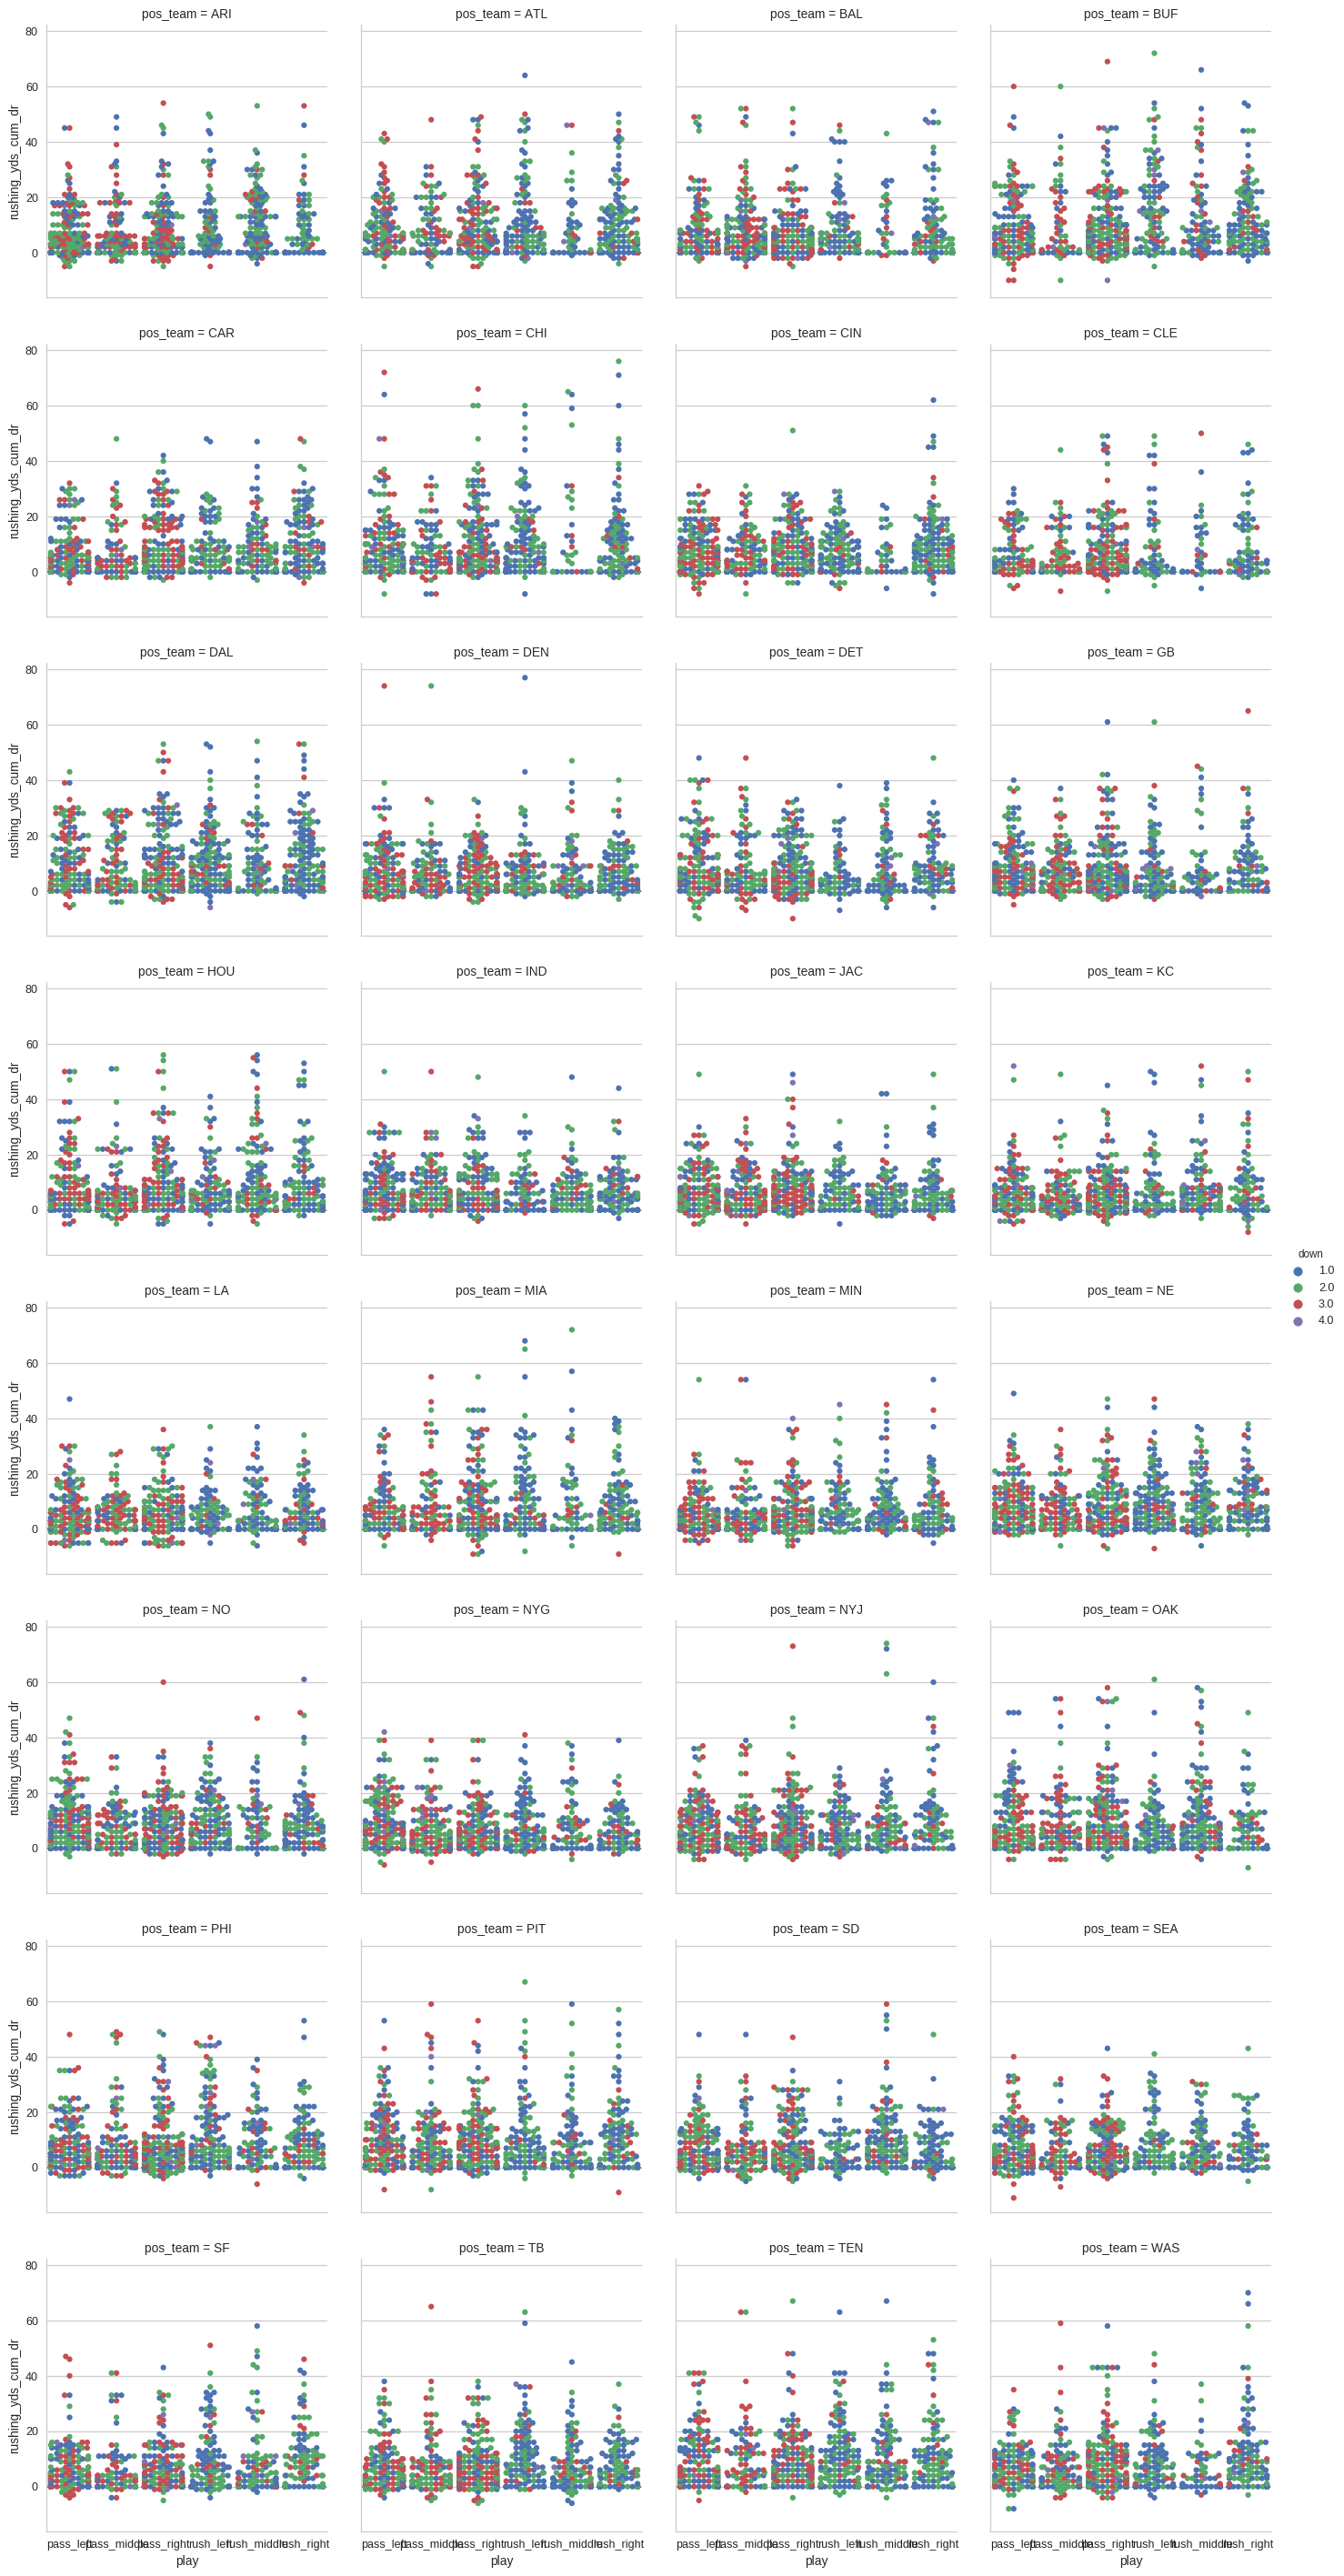

In [33]:
sns.factorplot(x='play', y='rushing_yds_cum_dr', hue='down',
              col='pos_team', data=pfi, col_wrap=4, kind='swarm')

## Distribution of score differential by play type and game quarter for each team

* teams are more likely to pass when losing and rush when winning
* the pass bias is more pronounced in the 4th quarter, as expected

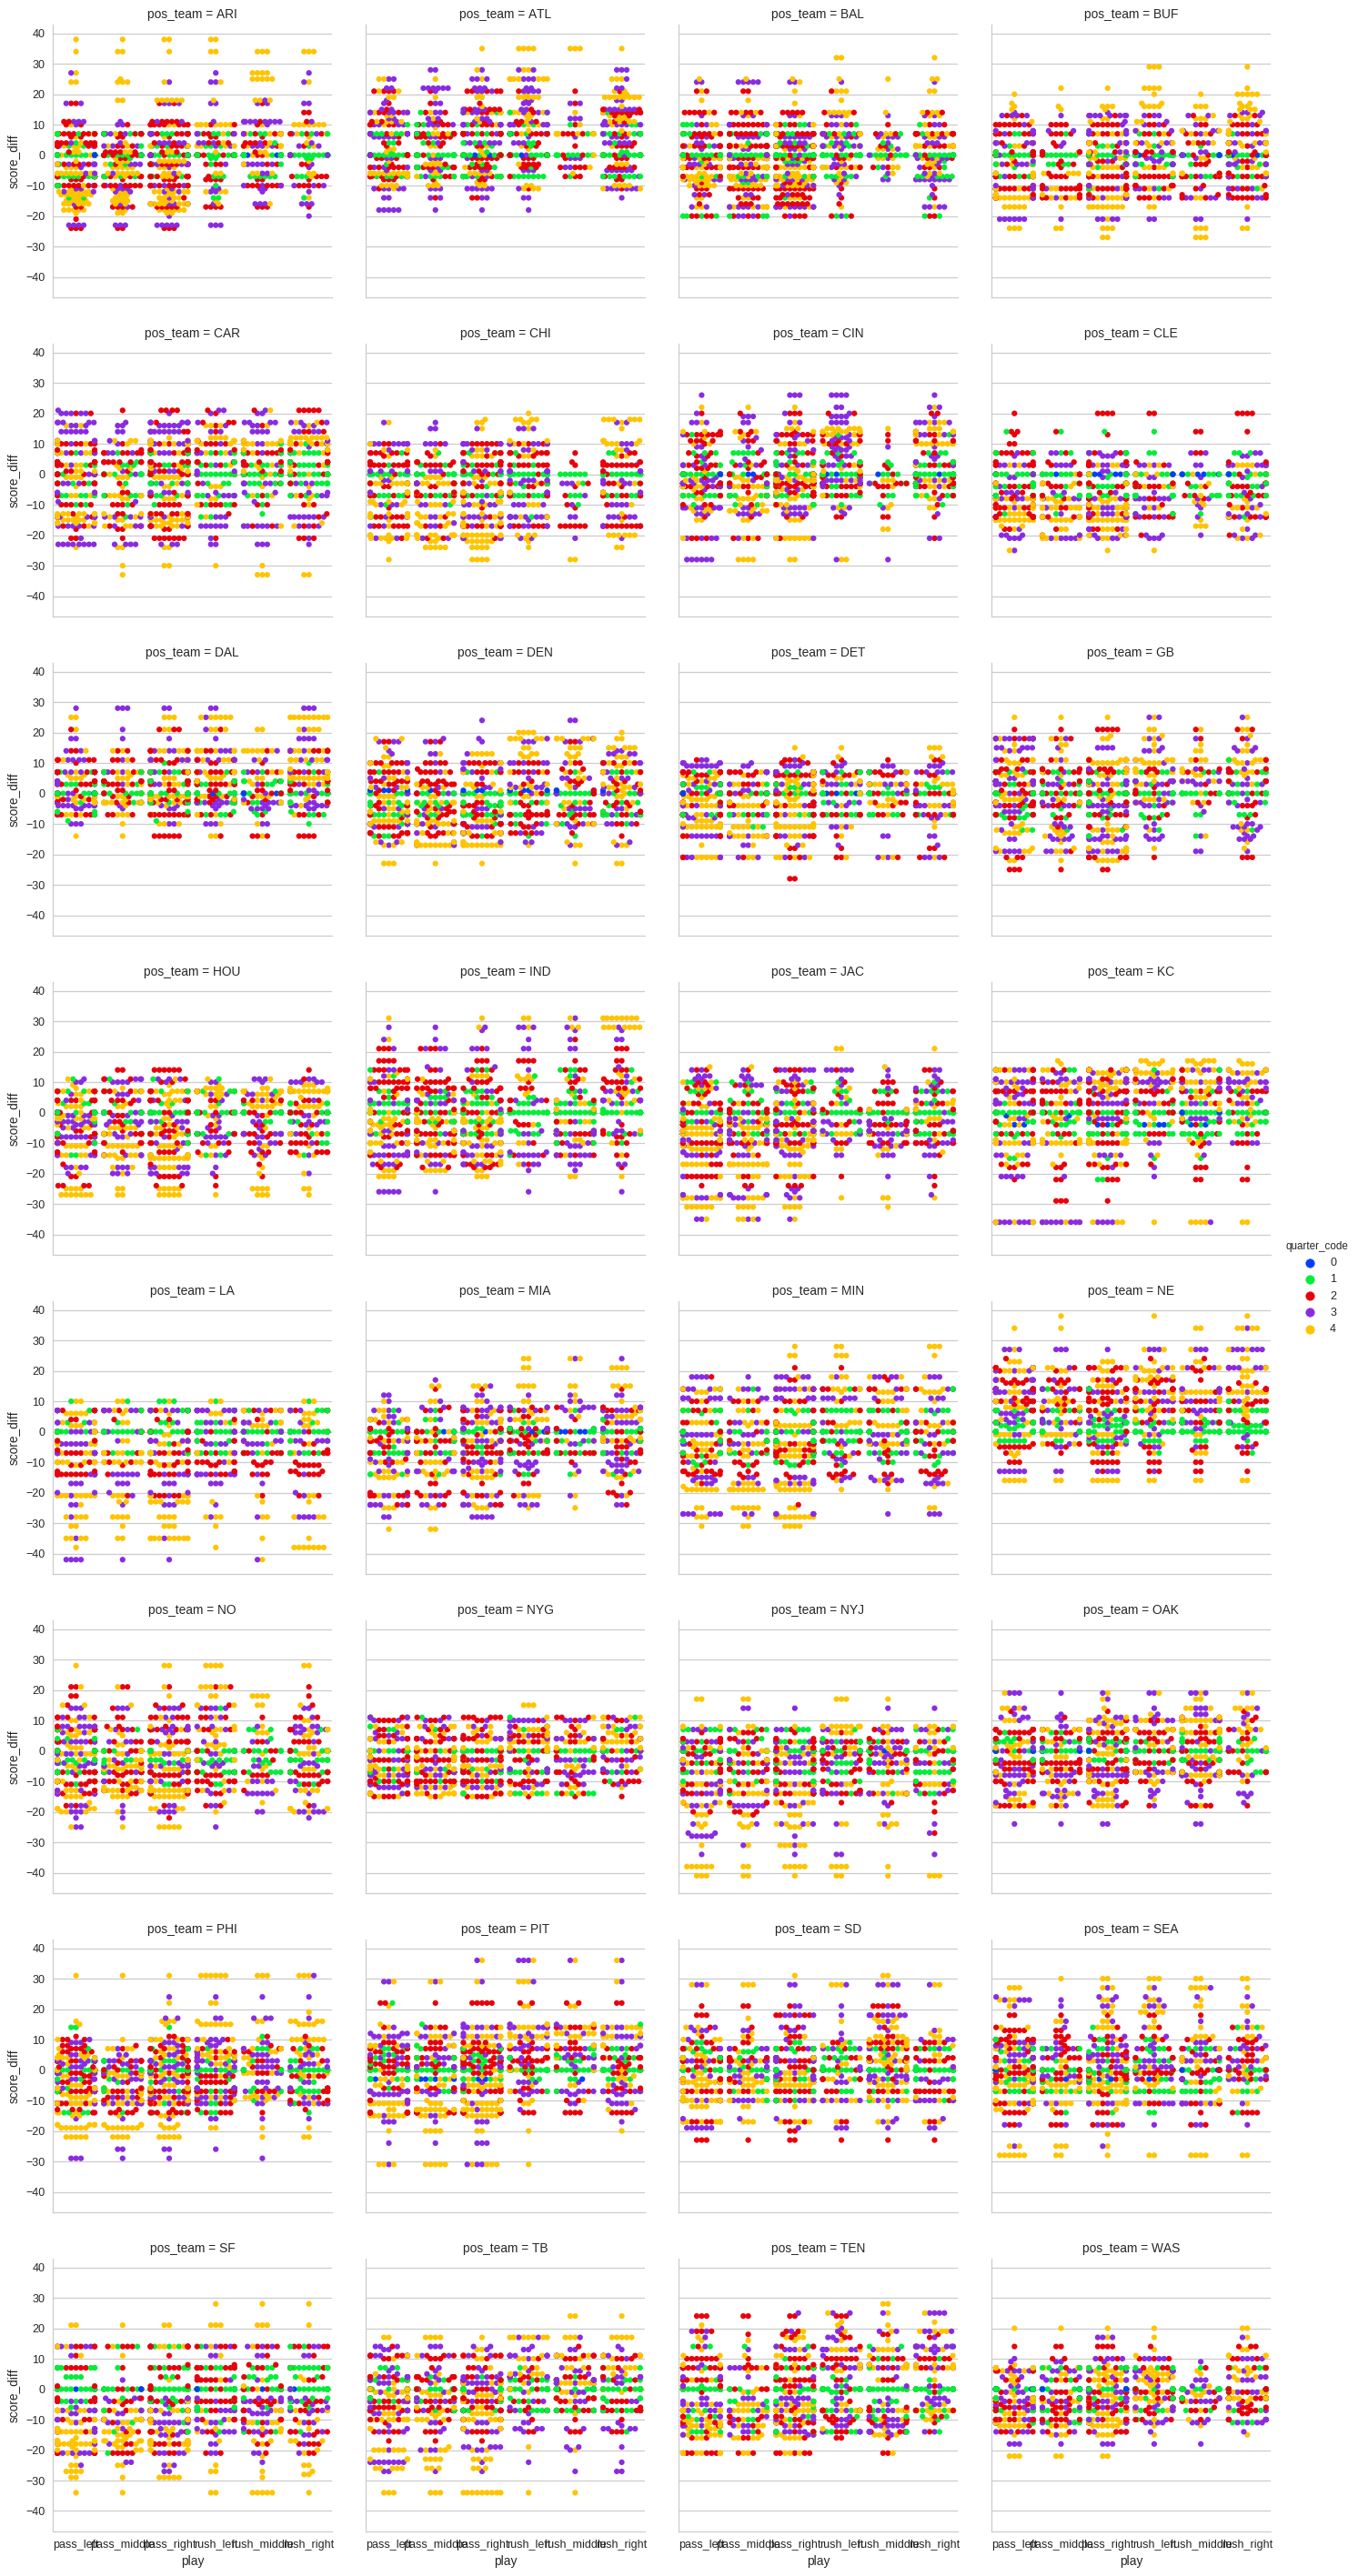

In [43]:
sns.factorplot(x='play', y='score_diff', hue='quarter_code',
              col='pos_team', data=pfi, col_wrap=4, kind='swarm', 
              palette='bright')

## Distribution of cumulative yards to go by play type and down for each team

* with more yards to get a first down, passing is more likely - especially on 3rd down

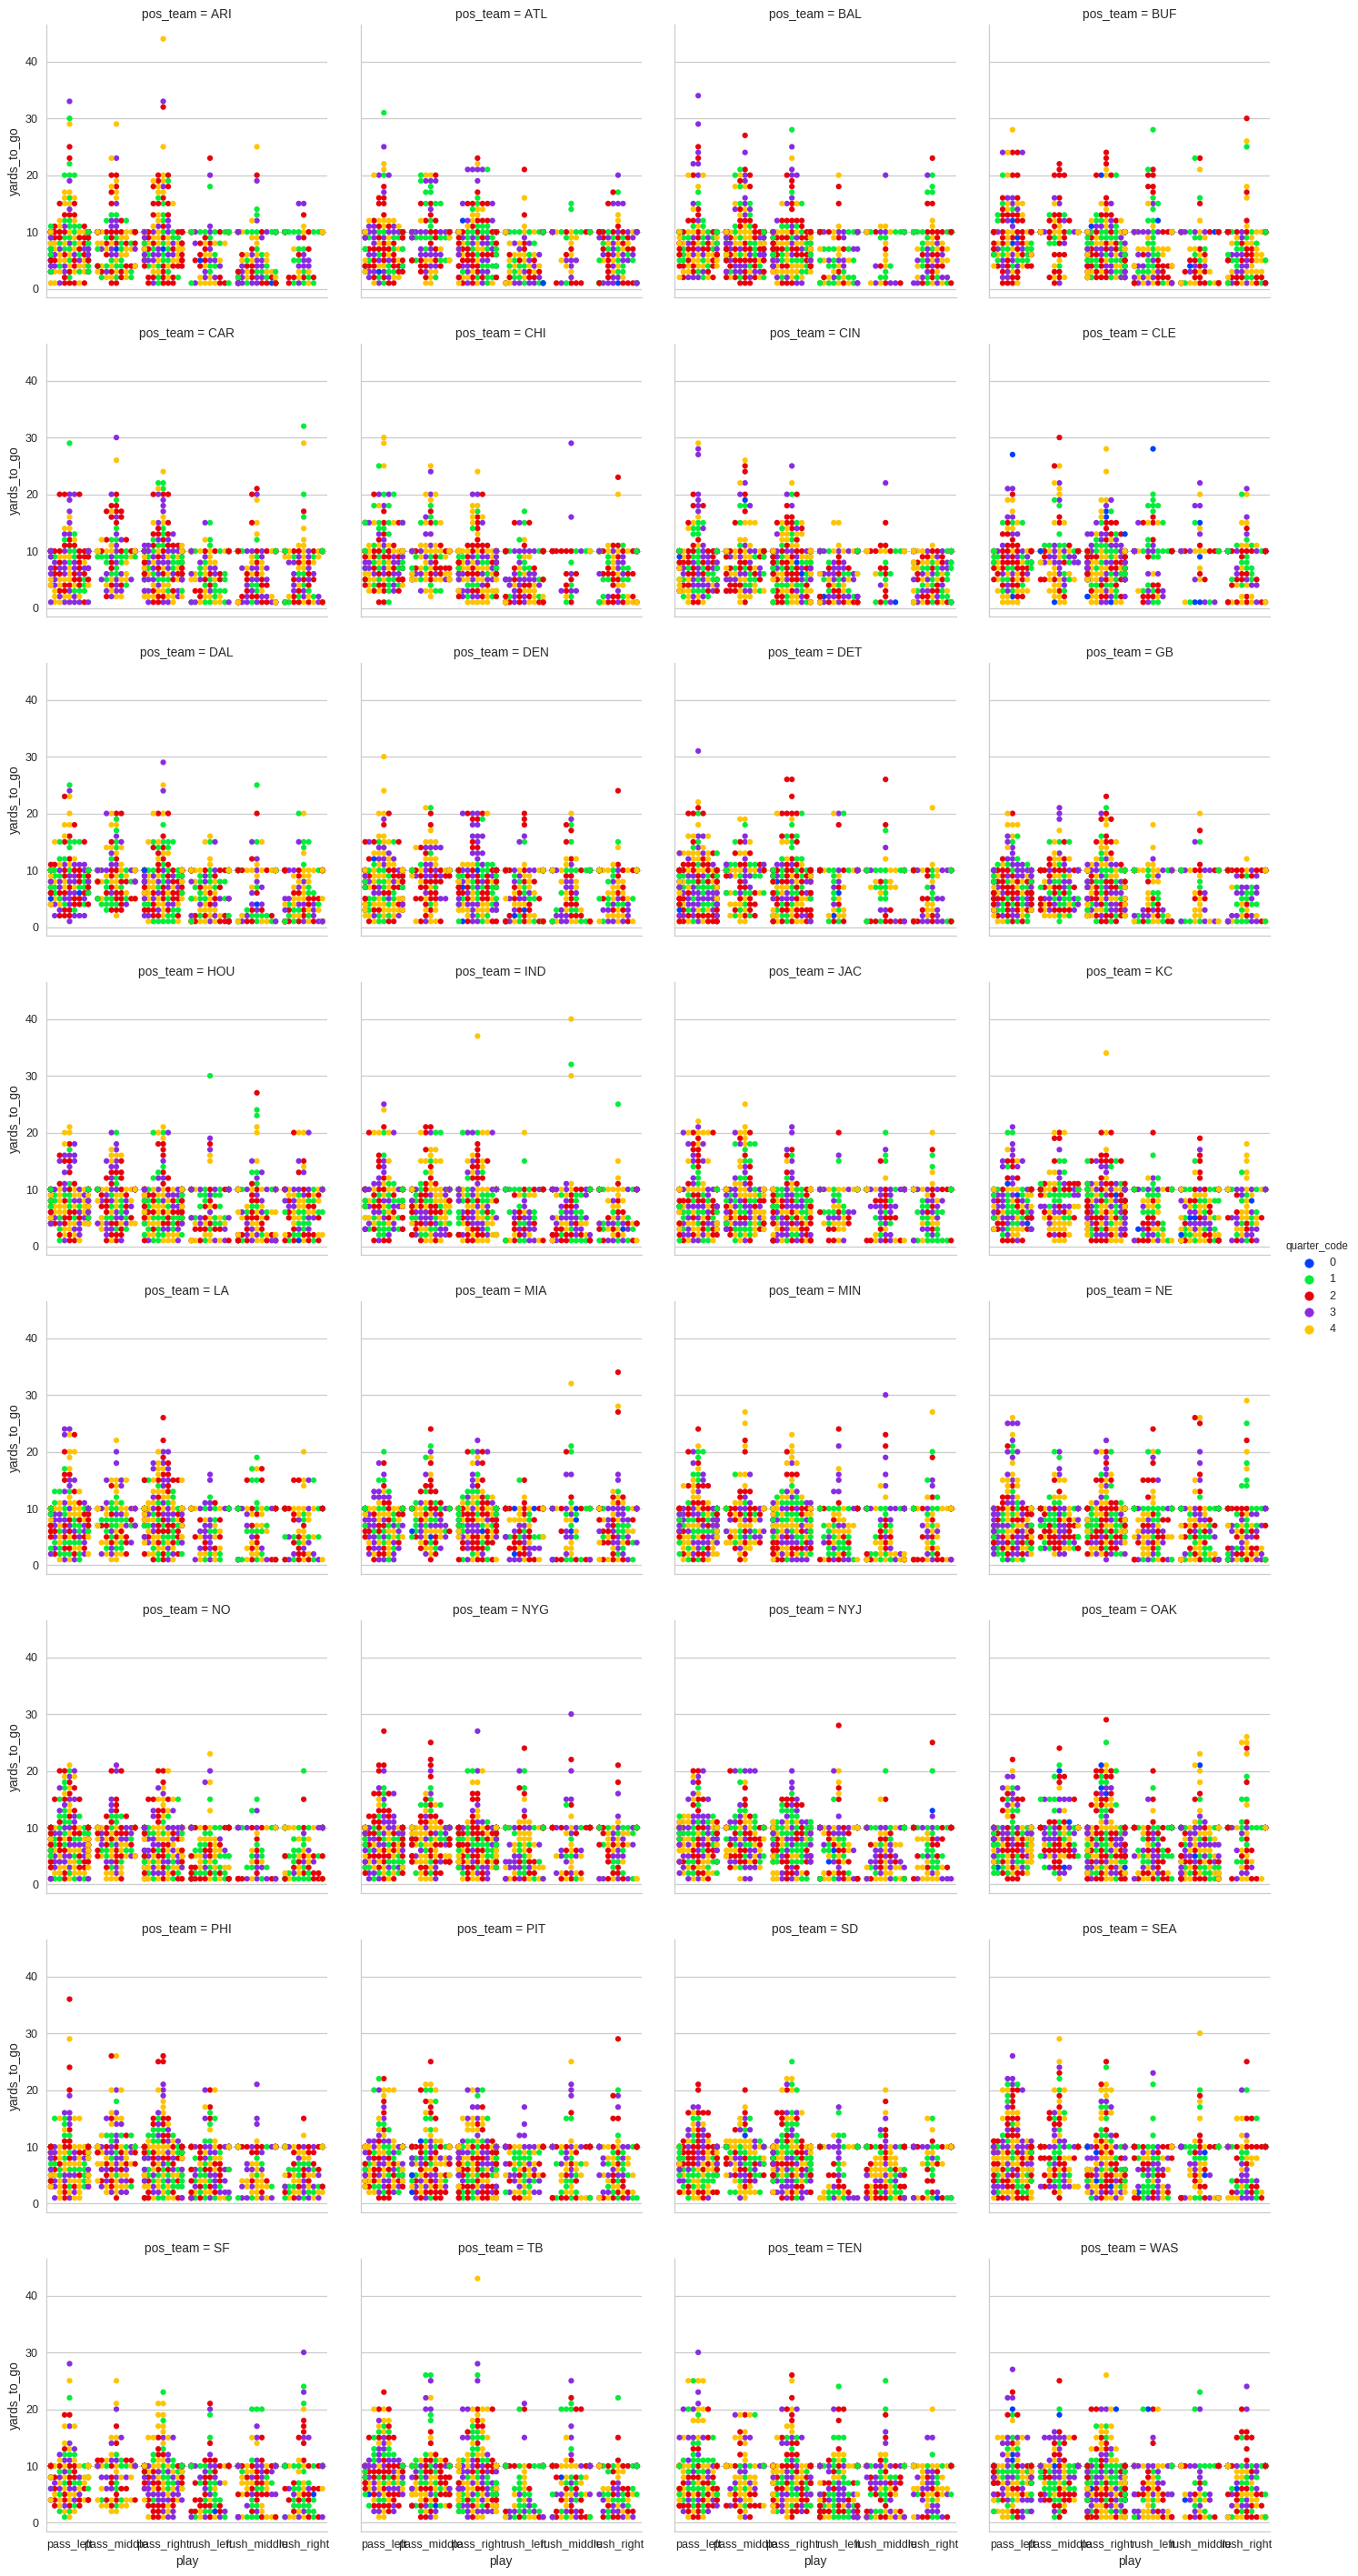

In [50]:
sns.factorplot(x='play', y='yards_to_go', hue='quarter_code',
              col='pos_team', data=pfi, col_wrap=4, kind='swarm', 
              palette='bright')

## Distribution of yards to go by play type and down for each team

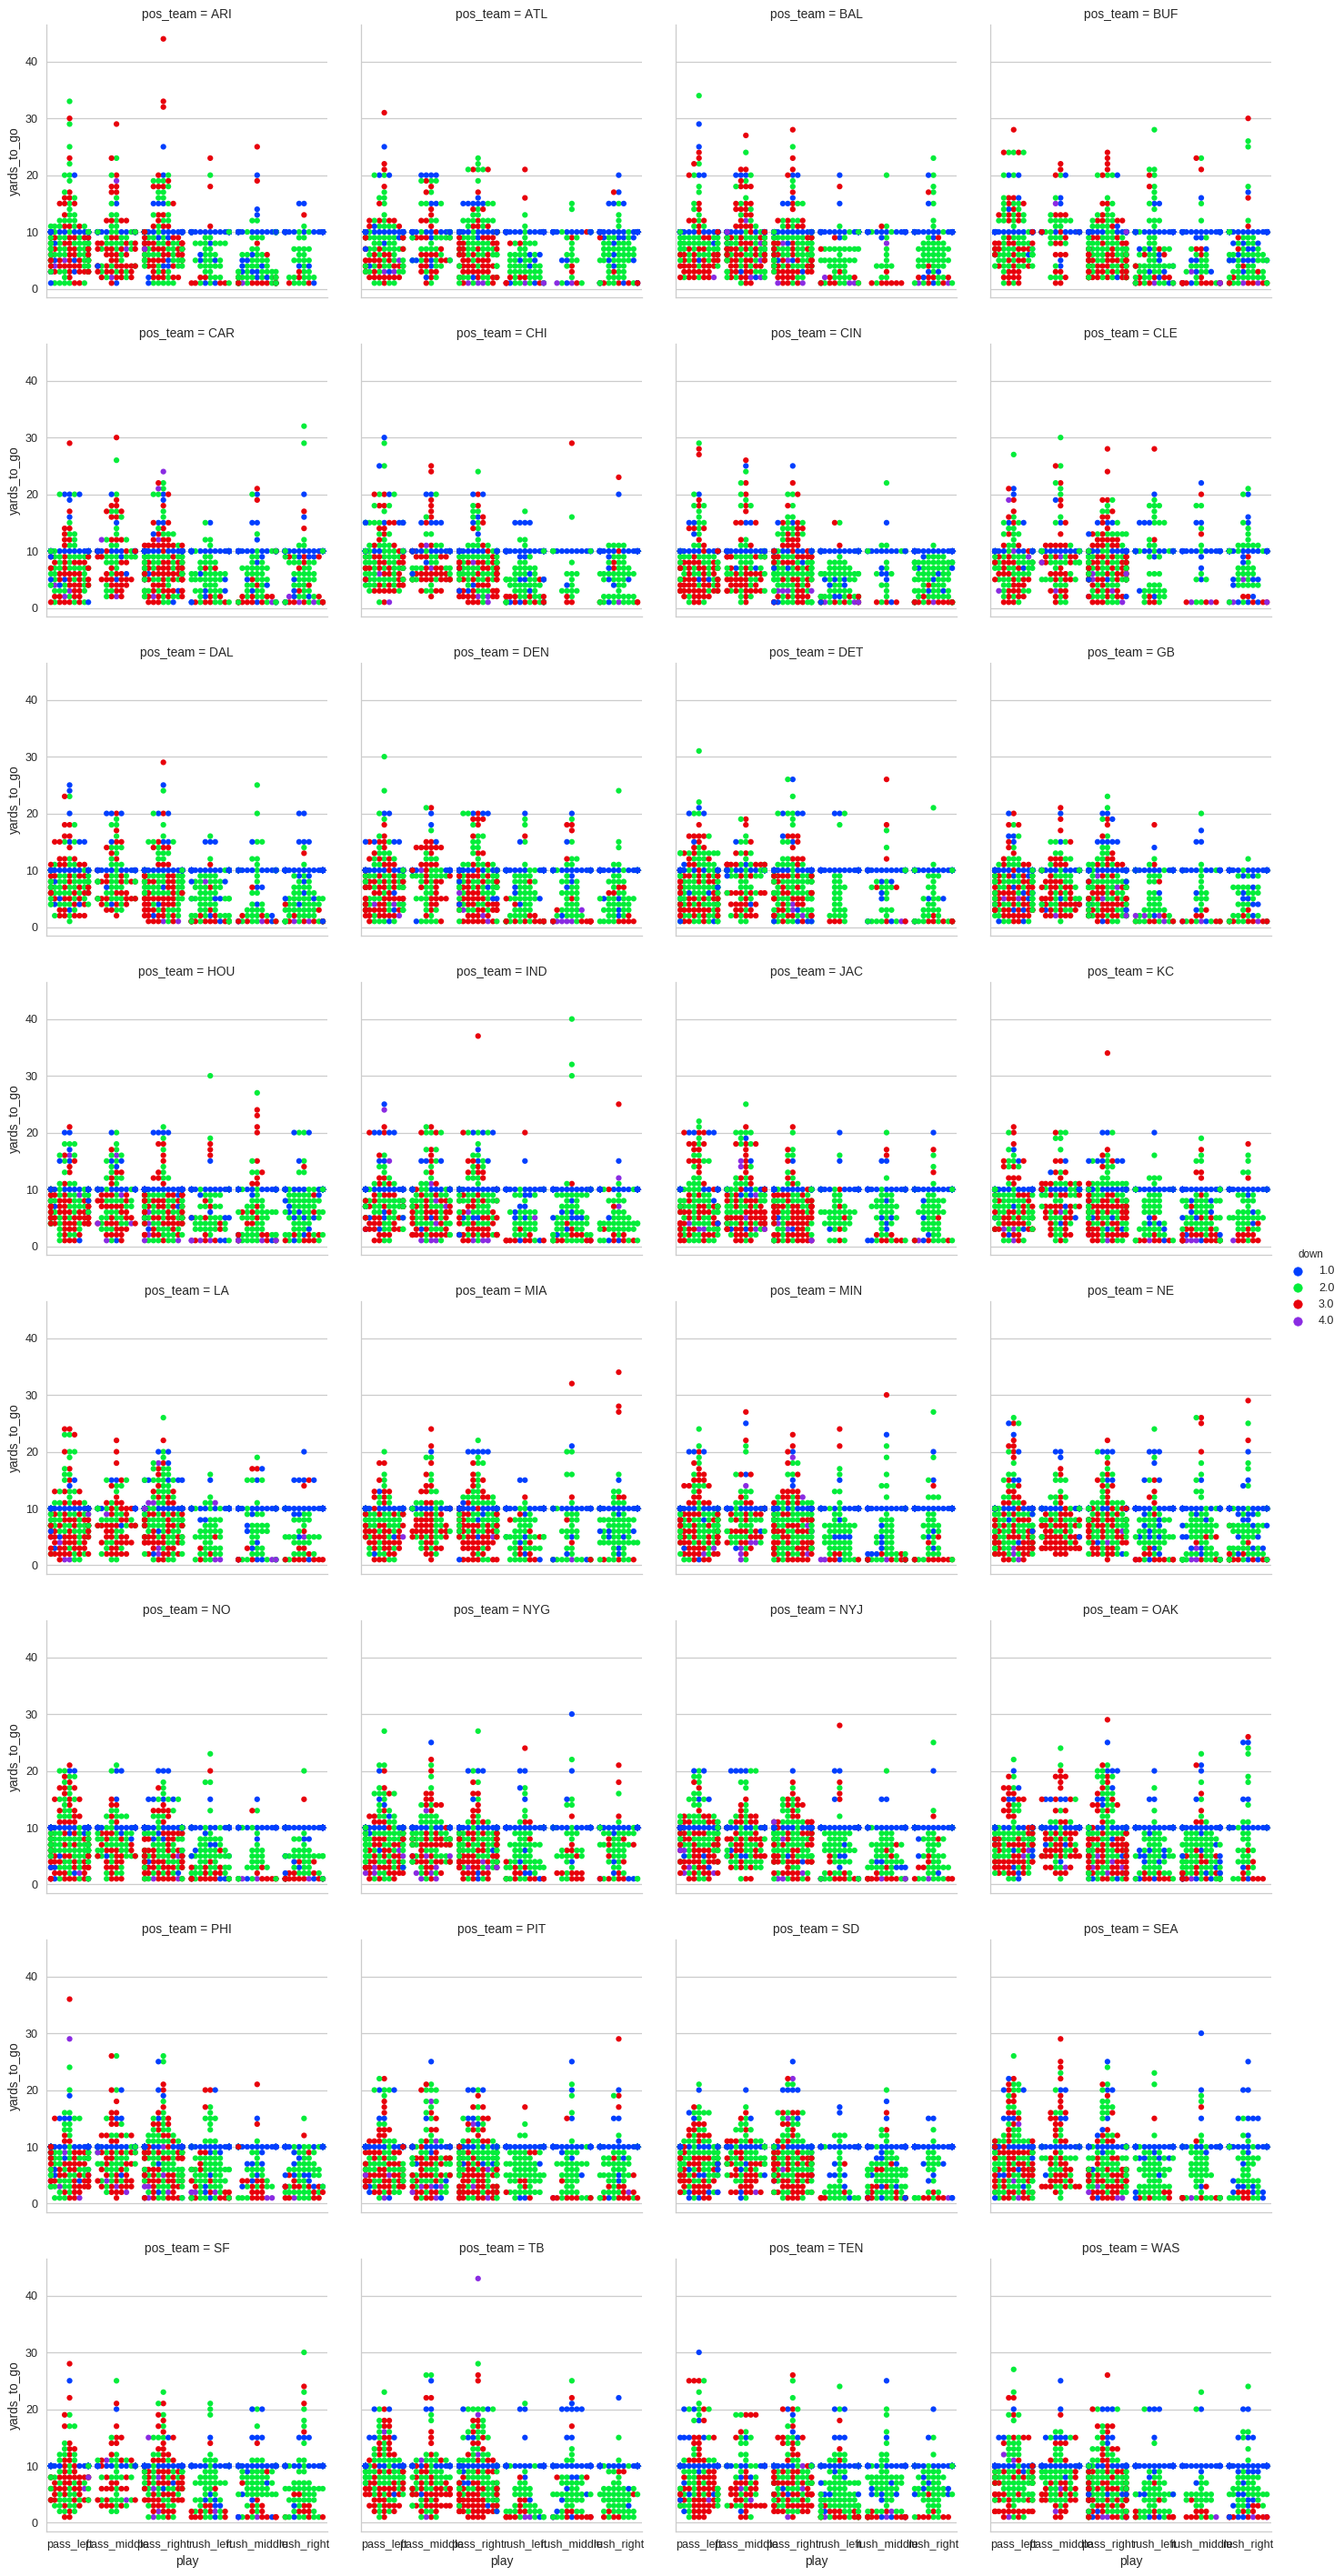

In [51]:
sns.factorplot(x='play', y='yards_to_go', hue='down',
              col='pos_team', data=pfi, col_wrap=4, kind='swarm', 
              palette='bright')